In [1]:
%pip install matplotlib numpy

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 13.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 17.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 21.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.7/300.7 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 20.3 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


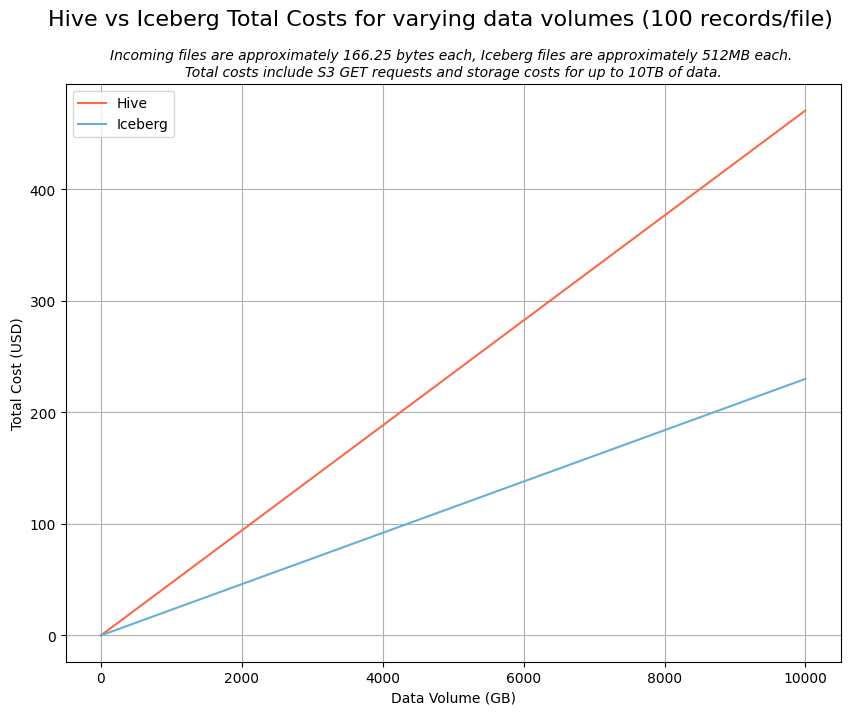

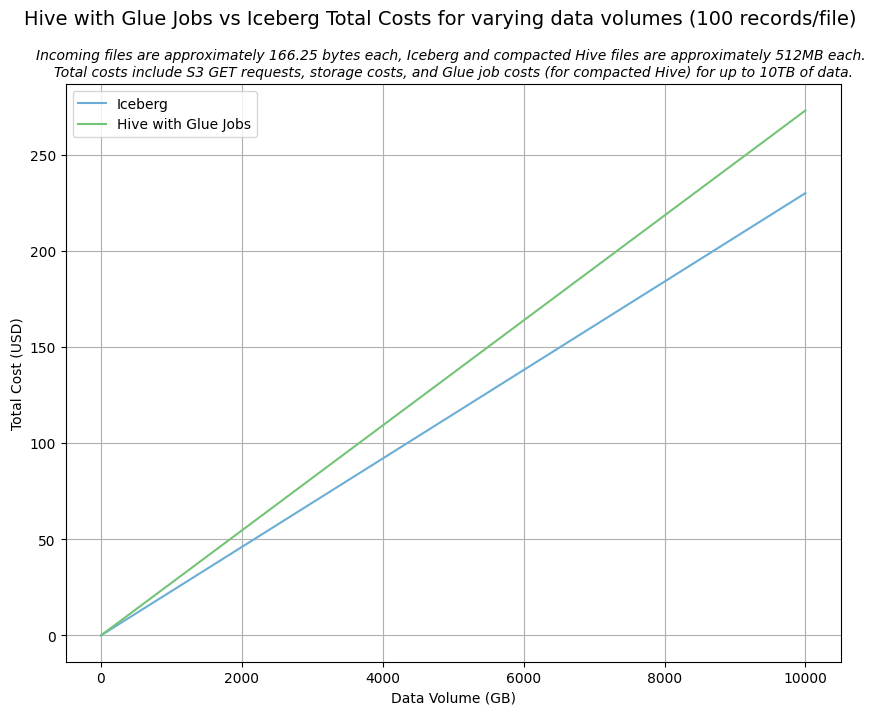

In [9]:
import numpy as np
import matplotlib.pyplot as plt

S3_COSTS = {
    "s3_get_cost_per_thousand": 0.0004,  # dollars
    "s3_storage_cost_per_gb": 0.023,  # dollars
}

GLUE_COSTS = {
    "glue_cost_per_dpu_hour": 0.44,  # dollars
}

DATA_CONSTANTS = {
    "data_gb": np.linspace(0, 10000, num=100),  # up to 10 terabytes
    "incoming_file_size_bytes": 166.25,  # bytes
    "iceberg_file_size_bytes": 512 * 1e6,  # bytes
    "hive_compacted_file_size_bytes": 512 * 1e6,  # bytes
    "batch_size": 100  # number of files per batch
}

def calculate_get_requests_and_costs(data_gb, file_size_bytes):
    # Calculate the number of GET requests and the associated costs
    data_bytes = data_gb * 1e9  # convert GB to bytes
    num_files = data_bytes / file_size_bytes  # total number of files
    num_batches = num_files / DATA_CONSTANTS["batch_size"]
    num_get_requests = num_batches  # each batch read is a GET request
    get_requests_per_thousand = num_get_requests / 1e3  # convert to thousands of GET requests
    cost = get_requests_per_thousand * S3_COSTS["s3_get_cost_per_thousand"]  # total cost

    return cost

def calculate_total_costs(data_gb, file_size_bytes):
    # Calculate the total costs for GET requests and storage
    get_request_cost = calculate_get_requests_and_costs(data_gb, file_size_bytes)
    storage_cost = data_gb * S3_COSTS["s3_storage_cost_per_gb"]
    total_cost = get_request_cost + storage_cost

    return total_cost

def calculate_glue_job_costs(data_gb):
    # Calculate the costs for Glue jobs
    data_tb = data_gb / 1024  # convert GB to TB
    glue_cost = data_tb * GLUE_COSTS["glue_cost_per_dpu_hour"] * 10  # 10 DPUs, 1 hour per TB

    return glue_cost

def calculate_total_costs_with_glue(data_gb, file_size_bytes):
    # Calculate the total costs for GET requests, storage, and Glue jobs
    get_request_cost = calculate_get_requests_and_costs(data_gb, file_size_bytes)
    storage_cost = data_gb * S3_COSTS["s3_storage_cost_per_gb"]
    glue_job_cost = calculate_glue_job_costs(data_gb)
    total_cost = get_request_cost + storage_cost + glue_job_cost

    return total_cost

def plot_hive_vs_iceberg_costs(data_gb, filename):

    # Plot the costs vs data volume for Hive and Iceberg
    plt.figure(figsize=(10, 7.5))
    
    hive_costs = np.vectorize(lambda data_gb: calculate_total_costs(data_gb, DATA_CONSTANTS["incoming_file_size_bytes"]))(data_gb)
    plt.plot(data_gb, hive_costs, label='Hive', color=plt.cm.Reds(0.5))
    
    iceberg_costs = np.vectorize(lambda data_gb: calculate_total_costs(data_gb, DATA_CONSTANTS["iceberg_file_size_bytes"]))(data_gb)
    plt.plot(data_gb, iceberg_costs, label='Iceberg', color=plt.cm.Blues(0.5))

    plt.xlabel('Data Volume (GB)')
    plt.ylabel('Total Cost (USD)')
    plt.suptitle('Hive vs Iceberg Total Costs for varying data volumes ({} records/file)'.format(DATA_CONSTANTS["batch_size"]), fontsize=16)
    plt.title('Incoming files are approximately 166.25 bytes each, Iceberg files are approximately 512MB each. \nTotal costs include S3 GET requests and storage costs for up to 10TB of data.', fontsize=10, fontstyle='italic')
    plt.legend()
    plt.grid(True)
    plt.savefig(filename, transparent=True)
    plt.show()

# Second Plot: Comparing costs between Hive with Glue jobs and Iceberg
def plot_hive_glue_vs_iceberg_costs(data_gb, filename):

    # Plot the total costs vs data volume for Hive with Glue jobs and Iceberg
    plt.figure(figsize=(10, 7.5))
    
    iceberg_costs = np.vectorize(lambda data_gb: calculate_total_costs(data_gb, DATA_CONSTANTS["iceberg_file_size_bytes"]))(data_gb)
    plt.plot(data_gb, iceberg_costs, label='Iceberg', color=plt.cm.Blues(0.5))
    
    hive_glue_costs = np.vectorize(lambda data_gb: calculate_total_costs_with_glue(data_gb, DATA_CONSTANTS["hive_compacted_file_size_bytes"]))(data_gb)
    plt.plot(data_gb, hive_glue_costs, label='Hive with Glue Jobs', color=plt.cm.Greens(0.5))

    plt.xlabel('Data Volume (GB)')
    plt.ylabel('Total Cost (USD)')
    plt.suptitle('Hive with Glue Jobs vs Iceberg Total Costs for varying data volumes ({} records/file)'.format(DATA_CONSTANTS["batch_size"]), fontsize=14)
    plt.title('Incoming files are approximately 166.25 bytes each, Iceberg and compacted Hive files are approximately 512MB each. \nTotal costs include S3 GET requests, storage costs, and Glue job costs (for compacted Hive) for up to 10TB of data.', fontsize=10, fontstyle='italic')
    plt.legend()
    plt.grid(True)
    plt.savefig(filename, transparent=True)
    plt.show()

# Generate the two plots
plot_hive_vs_iceberg_costs(DATA_CONSTANTS["data_gb"], filename="cost-comparision-03.png")
plot_hive_glue_vs_iceberg_costs(DATA_CONSTANTS["data_gb"], filename="cost-comparision-04.png")